In [1]:
import pandas as pd
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
import axelrod as axl
import axelrod.interaction_utils as iu

import testzd as zd

C, D = axl.Action.C, axl.Action.D

# Investigate whether or not a strategy is zero determinant.

In [1], given a match between 2 memory one strategies the concept of Zero Determinant strategies is introduced. This result showed that a player $p\in\mathbb{R}^4$ against a player $q\in\mathbb{R}^4$ could force a linear relationship between the scores.

Assuming the following:

- The utilities for player $p$: $S_x = (R, S, T, P)$ and for player $q$: $S_y = (R, T, S, P)$.
- The normalised long run score for player $p$: $s_x$ and for player $q$: $s_y$.
- Given $p=(p_1, p_2, p_3, p_4)$ a transformed (but equivalent) vector: $\tilde p=(p_1 - 1, p_2 - 1, p_3, p_4)$, similarly: $\tilde q=(1 - q_1, 1 - q_2, q_3, q_4)$

The main result of [1] is that:

if $\tilde p = \alpha S_x + \beta S_y + \gamma 1$ **or** if $\tilde q = \alpha S_x + \beta S_y + \gamma 1$ then:

$$
\alpha s_x + \beta s_y + \gamma 1 = 0
$$

where $\alpha, \beta, \gamma \in \mathbb{R}$

The question arises:

**Given a strategy $p$, is it a zero determinant strategy?**

This is equivalent to finding $\alpha, \beta, \gamma \in \mathbb{R}$ such that $\tilde p = \alpha S_x + \beta S_y + \gamma 1$.

Recall that $\tilde p, S_x, S_y, 1\in\mathbb{R}^{4\times 1}$ so this corresponds to a linear system of 4 equations on three variables.

$$\tilde p=Mx$$

Where:

$$
M = \begin{pmatrix}S_x, S_y, 1\end{pmatrix}\in\mathbb{R}^{4\times 3}
$$

As an example consider the `extort-2` strategy defined in [2]. This is given by:

$$p=(8/9, 1/2, 1/3, 0)$$

it is defined to ensure:

$$
\begin{aligned}
\alpha s_x - P &= 2(s_y - P)\\
\alpha s_x - 2s_y + P&=0\\
\end{aligned}
$$

Let us solve $Mx=\tilde p$

In [2]:
R, S, T, P = sym.S(3), sym.S(0), sym.S(5), sym.S(1)

tilde_p = sym.Matrix([sym.S(8) / 9 - 1, sym.S(1) / 2 - 1, sym.S(1) / 3, sym.S(0)])
M = sym.Matrix([[R, R, 1], 
                [S, T, 1],
                [T, S, 1], 
                [P, P, 1]])

In [3]:
system = (M, tilde_p)
symbols = sym.symbols("alpha, beta, gamma")
sym.linsolve(system, symbols)

{(1/18, -1/9, 1/18)}

This gives $\alpha = 1 / 18$, $\beta = -1/9$ and $\gamma = 1 / 18$ which ensures:

$$
1/18 s_x -1/9 s_y + 1/18 = 0
$$

multiplying this by 18 gives:


$$
s_x -2 s_y + 1 = 0
$$

which is the relationship described above.

Note that in practice, a vector $p$ might not be defined exactly: indeed it could be measured from observation. Thus: $p\notin\mathbb{Q}^{4\times 1}$ but $p\in\mathbb{R}^{4\times 1}$. As such that linear equations may no longer have exact solutions and/or indeed have no solutions at all as $M$ is not a square matrix. In this case, we can find the best fitting $\bar x=(\bar\alpha, \bar\beta, \bar\gamma)$ which minimises:

$$
\delta = \|M x-\tilde p\|_2= \sum_{i=1}^{4}\left((M\bar x)_i-\tilde p_i\right)^2
$$

Note that $\delta$ is the square of the Frobenius norm [3] and $\delta$ itself becomes a measure of how close $p$ is to being a ZD strategy.

Thus we define a $\delta$-ZD strategy as a strategy for which there exists $\bar x = \text{argmin}_x\|M x-\tilde p\|_2$ such that $\|M \bar x-\tilde p\|_2\leq \delta$.

We can see that `Extort-2` is $\delta$-ZD for a very low value of $\delta$:

In [4]:
p = np.array([8 / 9, 1 / 2, 1 / 3, 0])
zd.is_delta_ZD(p, delta=10 ** -7)

True

Note that the following vector is not:

$$p = (8 / 9, 1, 1 / 3, 0)$$

In [5]:
zd.is_delta_ZD(np.array([8 / 9, 1, 1 / 3, 0]), delta=10 ** -7)

False

Furthermore we can simulate the play of strategies and measure the probabilities:

In [6]:
players = axl.ZDExtort2(), axl.Alternator()
match = axl.Match(players, turns=10 ** 6)
axl.seed(0)
interactions = match.play()

In [7]:
def get_p_from_interactions(interactions):
    state_counter = iu.compute_state_to_action_distribution(interactions)[0]
    p = []
    for state in ((C, C), (C, D), (D, C), (D, D)):
        try:
            p.append(state_counter[(state, C)] / (state_counter[(state, C)]  + state_counter[(state, D)] ) )
        except ZeroDivisionError:
            p.append(np.NaN)
    return np.array(p)

In [8]:
p = get_p_from_interactions(interactions=interactions)
p

array([0.88787388, 0.49963841, 0.33404832, 0.        ])

We see that that measure of $p$ is not $\delta$-ZD for $\delta=10 ^ {-7}$:

In [9]:
zd.is_delta_ZD(p, delta=10 ** -7)

False

However it is for $\epsilon=10 ^ {-2}$:

In [10]:
zd.is_delta_ZD(p, delta=10 ** -2)

True

In fact the lowest $\delta$ for which $p$ is $\delta$-ZD is $\delta=10 ^ {-3}$:

In [11]:
zd.find_lowest_delta(p)

0.0001

## Dealing with missing states

When observing strategies it is possible that some pairs of strategies do not visit all potential states. For example a cooperator against a defector will never visit the state $(\text{D}, \text{C})$. On these occasions, the $\delta$-ZD definition can be modified. Given a set of visited states $S\subseteq \{\text{C}, \text{D}\} ^2$: we define:

$$
M', \tilde p'
$$

where $M', p'$ corresponds to the rows/elements of $M, \tilde p$ that are in $S$.

As before, we can then find the best fitting $\bar x=(\bar\alpha, \bar\beta, \bar\gamma)$ which minimises:

$$
\delta = \|M' x-\tilde p'\|_2= \sum_{i\text{ corresponding to }S}\left((M\bar x)_i-\tilde p_i\right)^2
$$

For example let us consider a match between a cooperator and the `extort-2` strategy:

In [12]:
players = axl.ZDExtort2(), axl.Cooperator()
match = axl.Match(players, turns=10 ** 6)
axl.seed(0)
interactions = match.play()
p = get_p_from_interactions(interactions)
p

array([0.88902872,        nan, 0.3330999 ,        nan])

In [13]:
zd.is_delta_ZD(p, delta=10 ** -7)

True

Note however that in the case of $|S|>1$ (ie there are any missing states) then there exists a unique solution to the corresponding equations: thus, technically in the case of missing states **all** strategies are in fact $\delta$-ZD for all $\delta\geq 0$.

https://en.wikipedia.org/wiki/Rouch%C3%A9%E2%80%93Capelli_theorem

In [14]:
zd.find_lowest_delta(p, step=10 ** -20)

1e-20

## Empirical observation

Let us measure the probabilities from two tournaments:

- The Stewart and Plotkin tournament of [2] which was written as a follow on to [1] highligting the impact of ZD strategies.
- A full tournament from the Axelrod Python project ([3] described in [4]): an open source library with over 200 strategies contributed from academics as well as the general public.

**TODO** Describe parameters etc...

## Evaluate the Press and Dyson tournament

Firslty let us look at the tournament of [2].

In [254]:
players = [axl.Cooperator(),
           axl.Defector(),
           axl.ZDExtort2(),
           axl.HardGoByMajority(),
           axl.Joss(),
           axl.HardTitForTat(),
           axl.HardTitFor2Tats(),
           axl.TitForTat(),
           axl.Grudger(),
           axl.GTFT(),
           axl.TitFor2Tats(),
           axl.WinStayLoseShift(),
           axl.Random(),
           axl.ZDGTFT2()]
player_names = [s.name for s in players]

df = pd.read_csv("data/processed/stewart_plotkin/std/overall/main.csv")
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df.sort_values("Score", ascending=False)

,Player index,complete,Score,P(C|CC),P(C|CD),P(C|DC),P(C|DD),P(CC),P(CD),P(DC),P(DD),delta,Player name
9,9,True,8013086,1.000000,0.333444,1.000000,0.333206,0.472555,0.041827,0.013064,0.044381,0.0062,GTFT
13,13,True,7977589,1.000000,0.125799,1.000000,0.251616,0.470131,0.039993,0.019746,0.060326,0.0001,ZD-GTFT-2
0,0,False,7889754,1.000000,1.000000,NaN,NaN,0.467133,0.065735,0.000000,0.000000,0.0000,Cooperator
10,10,True,7741074,1.000000,0.696729,1.000000,0.000000,0.488462,0.017753,0.005322,0.108866,0.1079,Tit For 2 Tats
6,6,True,7637499,1.000000,0.593560,0.324476,0.021769,0.488861,0.013974,0.008305,0.133799,0.0020,Hard Tit For 2 Tats
7,7,True,7556696,1.000000,0.000000,1.000000,0.000000,0.465703,0.034337,0.034257,0.146522,0.0001,Tit For Tat
8,8,True,7402932,1.000000,0.000000,0.000000,0.000000,0.487762,0.000122,0.024355,0.218744,0.2223,Grudger
5,5,True,7366876,1.000000,0.000000,0.144870,0.000000,0.487797,0.003192,0.021215,0.214124,0.1625,Hard Tit For Tat
11,11,True,7357490,1.000000,0.000000,0.000000,1.000000,0.440456,0.084404,0.034685,0.084344,0.5001,Win-Stay Lose-Shift
12,12,True,6450015,0.499802,0.500264,0.499260,0.499773,0.242477,0.272183,0.242864,0.272233,0.0556,Random


In [255]:
df[df["delta"] <= 10 ** -4]

,Player index,complete,Score,P(C|CC),P(C|CD),P(C|DC),P(C|DD),P(CC),P(CD),P(DC),P(DD),delta,Player name
0,0,False,7889754,1.000000,1.000000,NaN,NaN,0.467133,0.065735,0.000000,0.000000,0.0000,Cooperator
1,1,False,5049904,NaN,NaN,0.000000,0.000000,0.000000,0.000000,1.000000,4.853933,0.0000,Defector
2,2,True,4946368,0.889176,0.498667,0.332287,0.000000,0.338936,0.084521,0.237607,1.718412,0.0001,ZD-Extort-2
7,7,True,7556696,1.000000,0.000000,1.000000,0.000000,0.465703,0.034337,0.034257,0.146522,0.0001,Tit For Tat
13,13,True,7977589,1.000000,0.125799,1.000000,0.251616,0.470131,0.039993,0.019746,0.060326,0.0001,ZD-GTFT-2


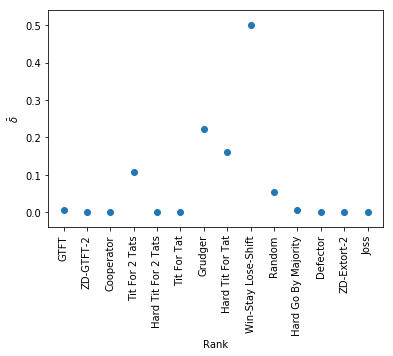

In [256]:
x_tick_locations = range(1, len(players) + 1)
ranks = df["Score"].rank(ascending=False)
sorted_indices = sorted(range(len(players)), key=lambda index: -df["Score"].iloc[index])
sorted_players = [players[i].name for i in sorted_indices]
plt.scatter(ranks, df["delta"])
plt.xlabel("Rank")
plt.ylabel(r"$\bar \delta$")
plt.xticks(range(1, len(players) + 1), sorted_players, rotation='vertical');

We can also consider pair wise matches:

In [257]:
df = pd.read_csv("data/processed/stewart_plotkin/std/per_opponent/main.csv")
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Opponent name"] = df.apply(lambda row: player_names[row["Opponent index"]], axis=1)

In [261]:
delta_array = np.zeros((len(players), len(players)))
mutual_cooperation_array = np.zeros((len(players), len(players)))
for index, row in df.iterrows():
    delta_array[row["Player index"], row["Opponent index"]] = row["delta"]
    mutual_cooperation_array[row["Player index"], row["Opponent index"]] = row["P(CC)"]

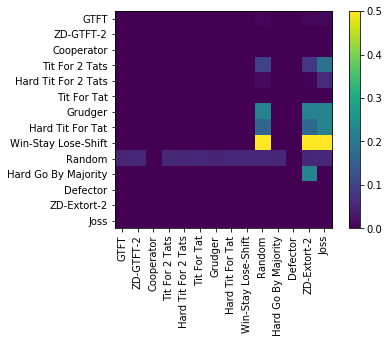

In [266]:
plt.imshow(delta_array[sorted_indices][:,sorted_indices])
plt.colorbar()
plt.xticks(range(len(players)), sorted_players, rotation='vertical')
plt.yticks(range(len(players)), sorted_players);

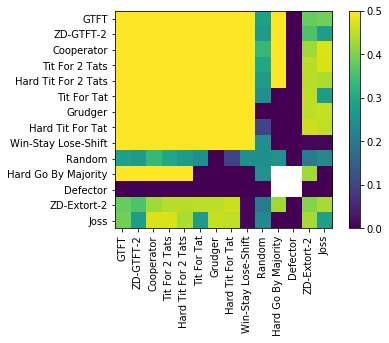

In [267]:
plt.imshow(mutual_cooperation_array[sorted_indices][:,sorted_indices])
plt.colorbar()
plt.xticks(range(len(players)), sorted_players, rotation='vertical')
plt.yticks(range(len(players)), sorted_players);

## Larger tournament

In [268]:
df = pd.read_csv("data/processed/full/std/overall/main.csv")
player_names = [s.name for s in axl.strategies if not s.classifier["long_run_time"]]
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df.sort_values("Score", ascending=False)

,Player index,complete,Score,P(C|CC),P(C|CD),P(C|DC),P(C|DD),delta,Player name
57,57,True,120065255,0.999799,0.465644,0.002453,0.188311,0.0871,Evolved HMM 5
56,56,True,120014479,0.938136,0.493200,0.207390,0.472371,0.0436,EvolvedLookerUp2_2_2
129,129,True,118918945,0.965872,0.183470,0.182635,0.345732,0.1269,PSO Gambler 2_2_2
128,128,True,118679065,1.000000,0.280005,0.000000,0.131937,0.1373,PSO Gambler 1_1_1
131,131,True,118432400,1.000000,0.522372,0.000000,0.120637,0.0644,PSO Gambler Mem1
52,52,True,118293800,0.992491,0.470112,0.000000,0.682506,0.1644,Evolved FSM 4
50,50,True,118022606,0.999898,0.929465,0.001431,0.000000,0.0011,Evolved ANN 5
54,54,True,117822482,0.998342,0.637350,0.038589,0.011921,0.0239,Evolved FSM 16 Noise 05
53,53,True,117293472,0.928433,0.668023,0.248184,0.191845,0.0012,Evolved FSM 16
49,49,True,117036210,0.999670,0.148253,0.035916,0.086179,0.1638,Evolved ANN


In [246]:
df["delta"].describe()

count    204.000000
mean       0.087604
std        0.147991
min        0.000000
25%        0.001350
50%        0.032700
75%        0.136325
max        1.388900
Name: delta, dtype: float64

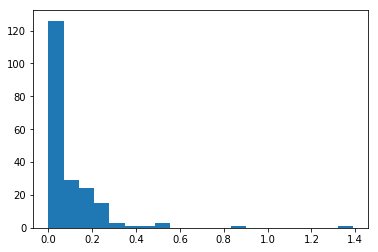

In [247]:
plt.hist(df["delta"], bins=20);

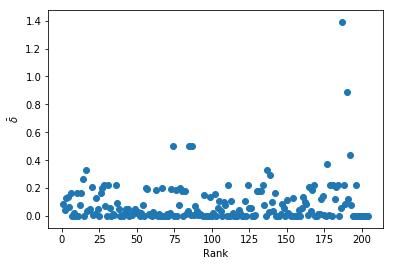

In [248]:
ranks = df["Score"].rank(ascending=False)
sorted_indices = sorted(range(len(players)), key=lambda index: -df["Score"].iloc[index])
sorted_players = [player_names[i] for i in sorted_indices]
plt.scatter(ranks, df["delta"])
plt.xlabel("Rank")
plt.ylabel(r"$\bar \delta$");

In [249]:
df.sort_values("Score", ascending=False).head(20)

,Player index,complete,Score,P(C|CC),P(C|CD),P(C|DC),P(C|DD),delta,Player name
57,57,True,120065255,0.999799,0.465644,0.002453,0.188311,0.0871,Evolved HMM 5
56,56,True,120014479,0.938136,0.493200,0.207390,0.472371,0.0436,EvolvedLookerUp2_2_2
129,129,True,118918945,0.965872,0.183470,0.182635,0.345732,0.1269,PSO Gambler 2_2_2
128,128,True,118679065,1.000000,0.280005,0.000000,0.131937,0.1373,PSO Gambler 1_1_1
131,131,True,118432400,1.000000,0.522372,0.000000,0.120637,0.0644,PSO Gambler Mem1
52,52,True,118293800,0.992491,0.470112,0.000000,0.682506,0.1644,Evolved FSM 4
50,50,True,118022606,0.999898,0.929465,0.001431,0.000000,0.0011,Evolved ANN 5
54,54,True,117822482,0.998342,0.637350,0.038589,0.011921,0.0239,Evolved FSM 16 Noise 05
53,53,True,117293472,0.928433,0.668023,0.248184,0.191845,0.0012,Evolved FSM 16
49,49,True,117036210,0.999670,0.148253,0.035916,0.086179,0.1638,Evolved ANN


In [250]:
df = pd.read_csv("data/processed/full/std/per_opponent/main.csv")
df["Player name"] = df.apply(lambda row: player_names[row["Player index"]], axis=1)
df["Opponent name"] = df.apply(lambda row: player_names[row["Opponent index"]], axis=1)

In [251]:
array = np.zeros((len(player_names), len(player_names)))
for index, row in df.iterrows():
    array[row["Player index"], row["Opponent index"]] = row["delta"]

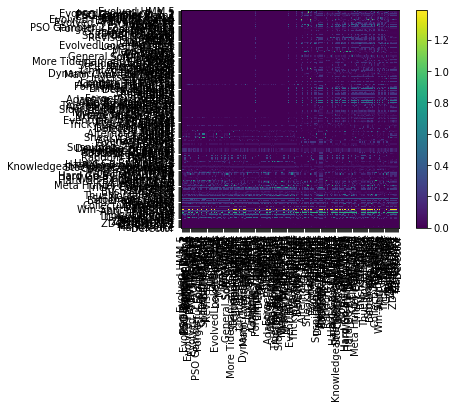

In [252]:
plt.imshow(array[sorted_indices][:,sorted_indices])
plt.colorbar();
plt.xticks(range(len(sorted_players)), sorted_players, rotation='vertical')
plt.yticks(range(len(sorted_players)), sorted_players);

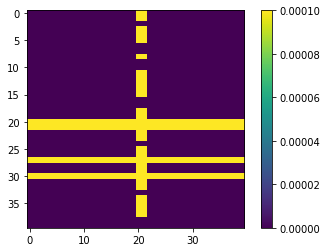

In [253]:
plt.imshow(array[sorted_indices][:,sorted_indices][:40,:40])
plt.colorbar();

## References

[1] Press, William H., and Freeman J. Dyson. "Iterated Prisoner’s Dilemma contains strategies that dominate any evolutionary opponent." Proceedings of the National Academy of Sciences 109.26 (2012): 10409-10413

[2] Stewart, Alexander J., and Joshua B. Plotkin. "Extortion and cooperation in the Prisoner’s Dilemma." Proceedings of the National Academy of Sciences 109.26 (2012): 10134-10135.

[3] Golub, Gene H., and Charles F. Van Loan. Matrix computations. Vol. 3. JHU Press, 2012.

[4] The Axelrod project developers. Axelrod: v4.2.0. 2016. http://doi.org/10.5281/zenodo.1252994

[5] Knight, Vincent, et al. "An Open Framework for the Reproducible Study of the Iterated Prisoner’s Dilemma." Journal of Open Research Software 4.1 (2016).